In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import IceCubeAnalysis_mojave as IceCubeAnalysis
from multiprocessing import Pool

In [78]:
def main(icecube_file_name, background_file_name, output_file_names,
         step_size=15, n_cpu=None):
    """
    Performs the all-sky source search. The script breaks the sky into
    a grid, with step between points defined by `step_size`. For each point,
    we find the most likely value of astrophysical neutrinos from the
    source at the given point. Creates a map of the max-likelihood and
    most-likely number of neutrinos from each point.
    Parameters
    ----------
    icecube_file_name : str
        IceCube pickle file location.
    background_file_name : str
        File location of pre-processed background PDF.
    output_file_names : array_like
        Output file names for fitted values of likelihood
        (0th entry) and n_s (1st entry).
    step_size : float
        The degrees step size to perform the all-sky search.
    n_cpu : int
        The number of CPUs to use in the parallelization.
        If n_cpu is None, the computation is not parallelized.
    """

    use_parallel = (n_cpu is not None)

    sourcesearch_ = IceCubeAnalysis.SourceSearch(icecube_file_name)
    sourcesearch_.load_background(background_file_name)

    catalog_data = np.load("./processed_data/radio_catelogy.npz", allow_pickle = True)

    
    cat_ra = catalog_data["cat_ra"]
    cat_dec = catalog_data["cat_dec"]
    
    
    
    #  This is the coordinate of each point on the sky we are checking.
    #cord_s, ra_len, dec_len = IceCubeAnalysis.prepare_skymap_coordinates(step_size)
    cord_s = np.stack((cat_ra, cat_dec), axis =1)
    ra_len = len(cat_ra)
    dec_len = len(cat_dec)
    N_sky_pts = len(cord_s)

    print("Number of IceCube events: \t %i" % sourcesearch_.N)
    print("Number of skypoints to calc: \t %i" % N_sky_pts)

    start_time = time.time()

    if(use_parallel):
        pool = Pool(n_cpu)

        args_for_multiprocessing = [(np.array(cord_s[i_source]), i_source) for i_source in range(N_sky_pts)]
        results = pool.starmap(sourcesearch_.job_submission,
                               args_for_multiprocessing)

        pool.close()
    else:
        results = []
        for i_source in range(N_sky_pts):
            results += [sourcesearch_.job_submission(cord_s[i_source],
                                                     i_source)]

    end_time = time.time()

    if(use_parallel):
        print("Using parallel, time passed was: \t %f" % (end_time - start_time))
    else:
        print("Using nonparallel, time passed was: \t %f" % (end_time - start_time))

    results_ = [list(t) for t in zip(*results)]
    ns = results_[0]
    del_ln_L = results_[1]

    n_s_map = ns
    data_map = del_ln_L

    np.save(output_file_names[0], data_map)
    np.save(output_file_names[1], n_s_map)


if(__name__ == "__main__"):
    icecube_file_name = "./processed_data/output_icecube_data_time.npz"
    background_file_name = "./processed_data/output_icecube_background_count_time_before.npz"
    output_file_names = ["./processed_data/calculated_fit_likelihood_map_allsky_test_new.npy",
      
                         "./processed_data/calculated_fit_ns_map_allsky_test_new.npy"]
    main(icecube_file_name, background_file_name, output_file_names, step_size=15, n_cpu=None)

Number of IceCube events: 	 931911
Number of skypoints to calc: 	 436
0) 	 n_s = 	 0.000000
Using nonparallel, time passed was: 	 21.380452


(436,)


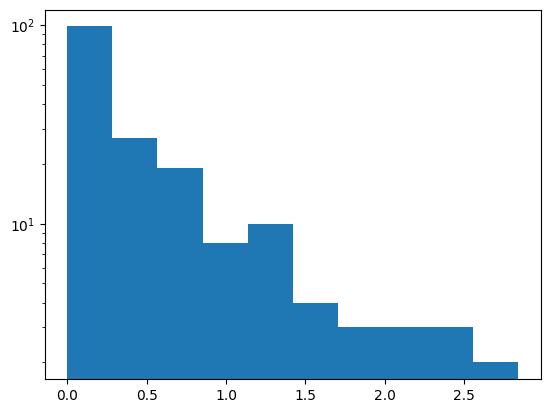

In [79]:
likelihood_map = np.load("./processed_data/calculated_fit_likelihood_map_allsky_test_new.npy",
                             allow_pickle=True)
likelihood_map[likelihood_map <= 0.0] = 0.0

ns_map = np.load("./processed_data/calculated_fit_ns_map_allsky_test_new.npy", allow_pickle = True)
ns_map[ns_map<=0.0] = 0.0
print(np.shape(ns_map))
plt.hist(likelihood_map[ns_map!=0])
plt.yscale('log')

In [80]:
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit


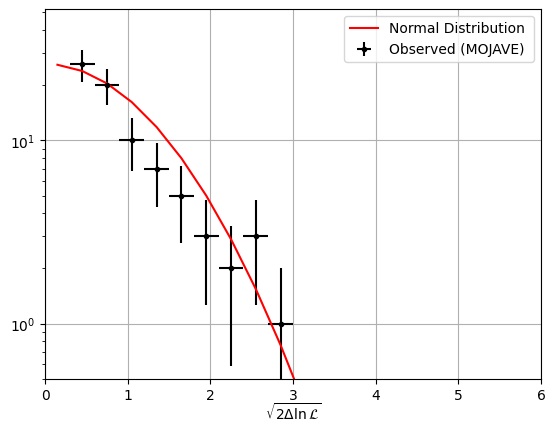

In [81]:
counts, bin_edges = np.histogram(likelihood_map[ns_map != 0],
                                     range=(0, 6),
                                     bins=20)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
def log_gaus(x, a, b):
    return a + b * x * x 

bins_to_fit = counts != 0
popt, pcov = curve_fit(log_gaus,
                       bin_centers[bins_to_fit],
                       np.log(counts[bins_to_fit]))





fig, ax = plt.subplots()
ax.set_yscale('log')
ax.errorbar(bin_centers, counts, xerr=3/len(counts), yerr=np.sqrt(counts),
            color="black", label="Observed (MOJAVE) ", fmt='.')
ax.plot(bin_centers, np.exp(log_gaus(bin_centers, *popt)),
        color='red', label="Normal Distribution")
ax.set_ylim(0.5, 2.0 * counts[1])
ax.set_xlim(0.0, 6)
ax.set_xlabel("$\sqrt{2 \Delta \ln \mathcal{L}}$", labelpad=-1)
ax.grid()
ax.legend()
#plt.savefig('mojavetimedist.png', dpi=300)

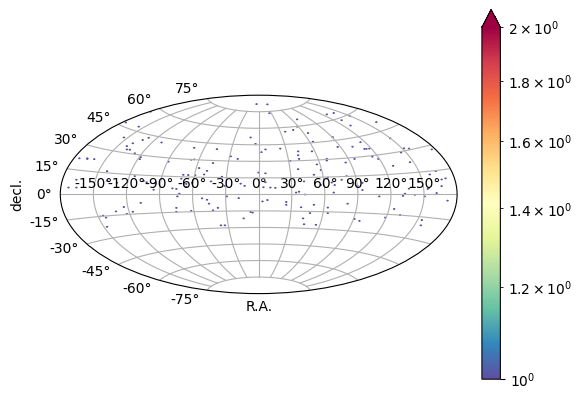

In [82]:
from astropy.coordinates import SkyCoord
from astropy import units



catalog_data = np.load("./processed_data/radio_catelogy.npz", allow_pickle = True)

cat_ra = catalog_data["cat_ra"]
cat_dec = catalog_data["cat_dec"]
cat_names = catalog_data["cat_names"]
cat_type = catalog_data["cat_type"]

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 0/256, N)
vals[:, 1] = np.linspace(1, 0/256, N)
vals[:, 2] = np.linspace(1, 100/256, N)
newcmp = ListedColormap(vals)
color_map = plt.cm.Spectral_r
coords = SkyCoord(ra=cat_ra,
                  dec=cat_dec,
                  unit='degree')

ra = coords.ra.wrap_at(180 * units.deg).radian
dec = coords.dec.radian


ax = plt.subplot(111, projection="aitoff")
image = ax.hexbin(ra, dec,
                  cmap=color_map,
                  gridsize=400,
                  mincnt=1,
                  bins='log')
ax.set_xlabel('R.A.')
ax.set_ylabel('decl.')
ax.grid(True)
cbar = plt.colorbar(image, spacing='uniform', extend='max')
plt.show()

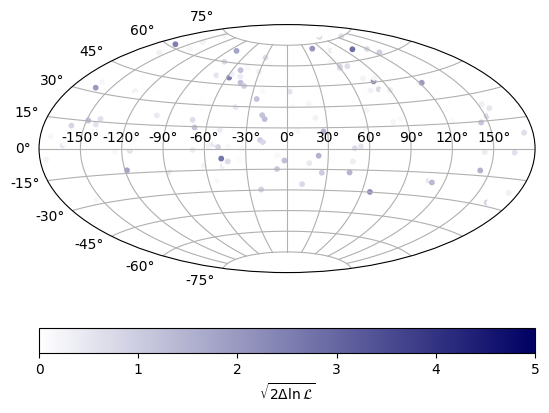

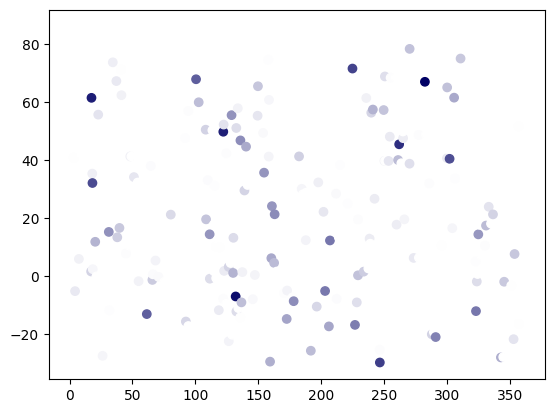

In [83]:
cat_names = catalog_data["cat_names"]
count = 0 
non0_ns = np.zeros(len(ns_map[ns_map!=0]))
non0_names = []
for i in range(len(ns_map)):
    if ns_map[i] != 0:
        non0_ns[count] = ns_map[i]
        non0_names.append(cat_names[i])
        count = count+1
        
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 0/256, N)
vals[:, 1] = np.linspace(1, 0/256, N)
vals[:, 2] = np.linspace(1, 100/256, N)
newcmp = ListedColormap(vals)

fig = plt.figure()
ax = fig.add_subplot(111, projection = "aitoff")
plt.scatter(np.deg2rad(cat_ra)-np.pi, np.deg2rad(cat_dec), c=likelihood_map, s = 10, cmap=newcmp, vmin = 0, vmax =5)
#cbar = plt.colorbar(pcolormesh, orientation="horizontal")
#cbar.set_label("$2 \Delta \ln \mathcal{L}$")
ax.grid(True)
plt.colorbar(orientation = "horizontal", label = "$\sqrt{2 \Delta \ln \mathcal{L}}$")
plt.savefig('mojaveaitoff.png', dpi=300)
plt.show()
plt.scatter(cat_ra, cat_dec, c=likelihood_map, cmap=newcmp)

In [84]:
import ROOT
def SingleFCLimit(bg,mu):
    CL = 0.9
    fc = ROOT.TFeldmanCousins(CL)
    fc.SetMuMax(50)
    
    Ntrials = 1000
    upper_limits = np.zeros(Ntrials)
    cache = {}
    for i in range(0, Ntrials):
        nobs = ROOT.gRandom.Poisson(mu+bg)
        
        if nobs in cache:
            upper_limits[i] = cache[nobs]
            
        else: 
            upper = fc.CalculateUpperLimit(nobs, bg)
            cache[nobs]=upper
            upper_limits[i]=upper
    median_upper_limit = np.median(upper_limits)
    return(median_upper_limit)

In [85]:
import glob
import scipy.interpolate

data_files = glob.glob("./data/tabulatedaeff/IC*.txt")
dec_steps =  np.array([])
eng_steps =  np.array([])
area_steps =  np.array([])
for data_file_name in data_files:
    print("Loading filename: %s" % data_file_name)
    f = open(data_file_name)


    data = np.loadtxt(data_file_name, dtype='float')
    dec_steps = np.append(dec_steps, (data[:,2]+data[:,3])/2)
    eng_steps = np.append(eng_steps, (data[:, 0]+data[:,1])/2)
    area_steps = np.append(area_steps, data[:,4])
    
unique_decs = np.unique(dec_steps)
avg_dec = np.zeros(len(unique_decs))
avg_eng = np.zeros(len(unique_decs))
avg_area = np.zeros(len(unique_decs))

for i in range(len(unique_decs)):
    avg_dec[i] = np.average(dec_steps[dec_steps == unique_decs[i]])
    avg_eng[i] = np.average(eng_steps[dec_steps == unique_decs[i]])
    avg_area[i] = np.average(area_steps[dec_steps == unique_decs[i]])
    
f_area = scipy.interpolate.interp1d(avg_dec, avg_area, kind = "cubic", bounds_error = False, fill_value = "extrapolate")    

Loading filename: ./data/tabulatedaeff/IC86_I_effectiveArea.txt
Loading filename: ./data/tabulatedaeff/IC40_effectiveArea.txt
Loading filename: ./data/tabulatedaeff/IC59_effectiveArea.txt
Loading filename: ./data/tabulatedaeff/IC86_II_effectiveArea.txt
Loading filename: ./data/tabulatedaeff/IC79_effectiveArea.txt


['0938-076'] ['Galaxy']


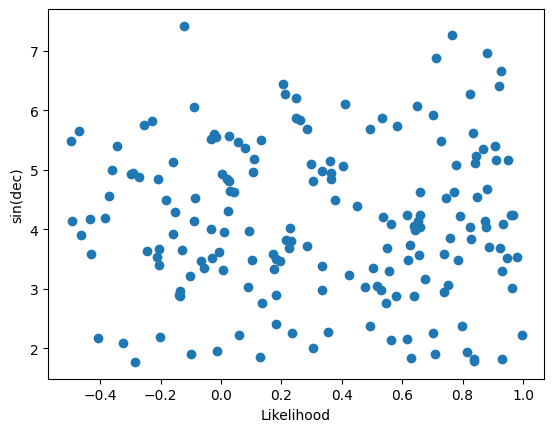

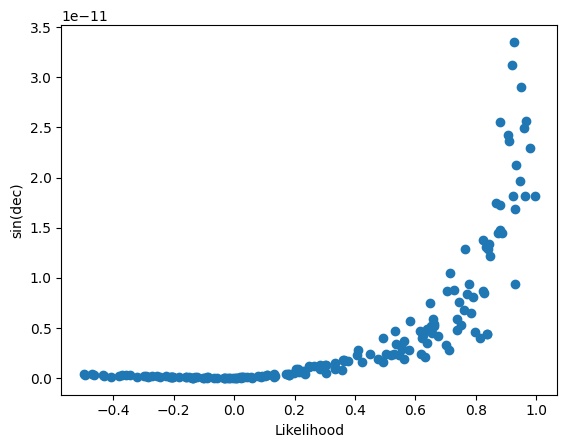

In [86]:
hi = np.linspace(0,178,177)
agn_names  = ['AGN', 'AGN_Candidate']
blazar_names = ["Blazar", "Blazar_Candidate"]
radio_names = ["Radio", "RadioG"]
sey_names = ["Seyfert_1", "Seyfert_2"]
qso_names = ["QSO"]
bll_names = ["BClG", "BLLac"]
other_names = ["LINER",  "X"]

print(cat_names[cat_type == "Galaxy"], cat_type[cat_type == "Galaxy"])

upper_lim = np.zeros(len(ns_map[ns_map !=0]))
lim_dec = cat_dec[ns_map !=0]
lim_type = cat_type[ns_map !=0]
lim_names = cat_names[ns_map != 0]
for i in range(len(upper_lim)): 
    
    upper_lim[i] = SingleFCLimit(ns_map[ns_map !=0][i], 0)


eff_areas = f_area(lim_dec)
lim_flux  = upper_lim/3.156e6/eff_areas

plt.scatter(np.sin(np.deg2rad(cat_dec[ns_map !=0])), upper_lim) 
plt.xlabel("Likelihood")
plt.ylabel("sin(dec)")
plt.show()
plt.scatter(np.sin(np.deg2rad(lim_dec)), lim_flux) 
plt.xlabel("Likelihood")
plt.ylabel("sin(dec)")
plt.show()

In [87]:
argsort_ = np.argsort(lim_flux)
descending_sort = argsort_[::-1]
#cat_type = cat_type[descending_sort]
#lim_dec = lim_dec[descending_sort]


agn = np.logical_or(lim_type[descending_sort] == agn_names[1], lim_type[descending_sort] == agn_names[0])
blazar = np.logical_or(lim_type[descending_sort] == blazar_names[1], lim_type[descending_sort] == blazar_names[0])
radio = np.logical_or(lim_type[descending_sort] == radio_names[1], lim_type[descending_sort] == radio_names[0])
sey = np.logical_or(lim_type[descending_sort] == sey_names[1], lim_type[descending_sort] == sey_names[0])
qso = np.logical_or(lim_type[descending_sort] == qso_names[0], lim_type[descending_sort] == qso_names[0])
bll = np.logical_or(lim_type[descending_sort] == bll_names[0], lim_type[descending_sort] == bll_names[1])
other = np.logical_or(lim_type[descending_sort] == other_names[0], lim_type[descending_sort] == other_names[1])

print(len(qso[qso==True])/len(lim_type))
print(len(lim_flux))

0.4350282485875706
177


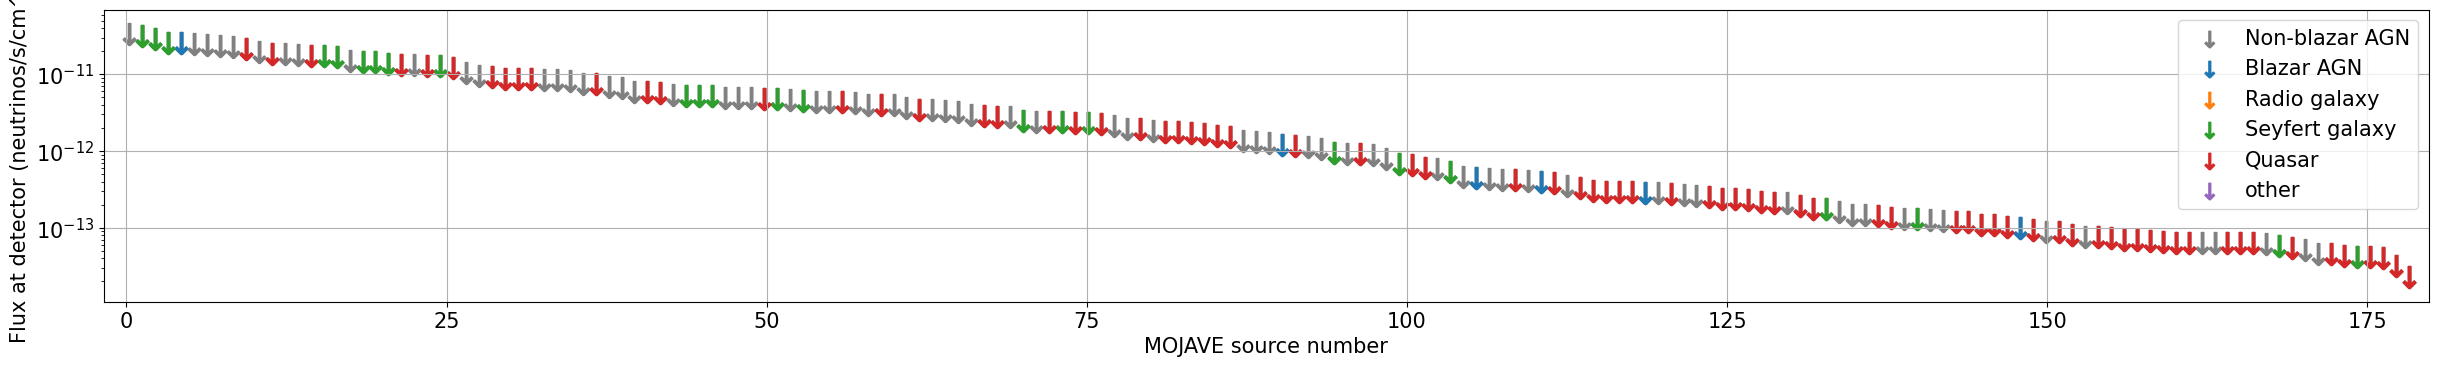

In [88]:
ticks = np.linspace(1, 260,178)
plt.figure(figsize = (30,4))
plt.scatter(hi, lim_flux[descending_sort],  marker=r'$\downarrow$', s = 250, label = "Non-blazar AGN", c = "grey")
plt.scatter(hi[blazar],lim_flux[descending_sort][blazar],marker=r'$\downarrow$', s = 250, label = "Blazar AGN")
plt.scatter(hi[radio],lim_flux[descending_sort][radio],marker=r'$\downarrow$', s = 250, label = "Radio galaxy")
plt.scatter(hi[sey],lim_flux[descending_sort][sey], marker=r'$\downarrow$', s = 250,label = "Seyfert galaxy")
plt.scatter(hi[qso],lim_flux[descending_sort][qso], marker=r'$\downarrow$', s = 250,label = "Quasar")
plt.scatter(hi[other],lim_flux[descending_sort][other], marker=r'$\downarrow$', s = 250,label = "other")

plt.legend(markerscale = 0.75, fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("MOJAVE source number", fontsize = 15)
plt.yscale("log")
plt.grid()
plt.ylabel("Flux at detector (neutrinos/s/cm^2)", fontsize = 15)
plt.margins(.01, .1)
plt.subplots_adjust(bottom=0.15)
#plt.savefig("./plots/upper_limits.pdf", dpi = 300)
plt.show()
#r'$\downarrow$'

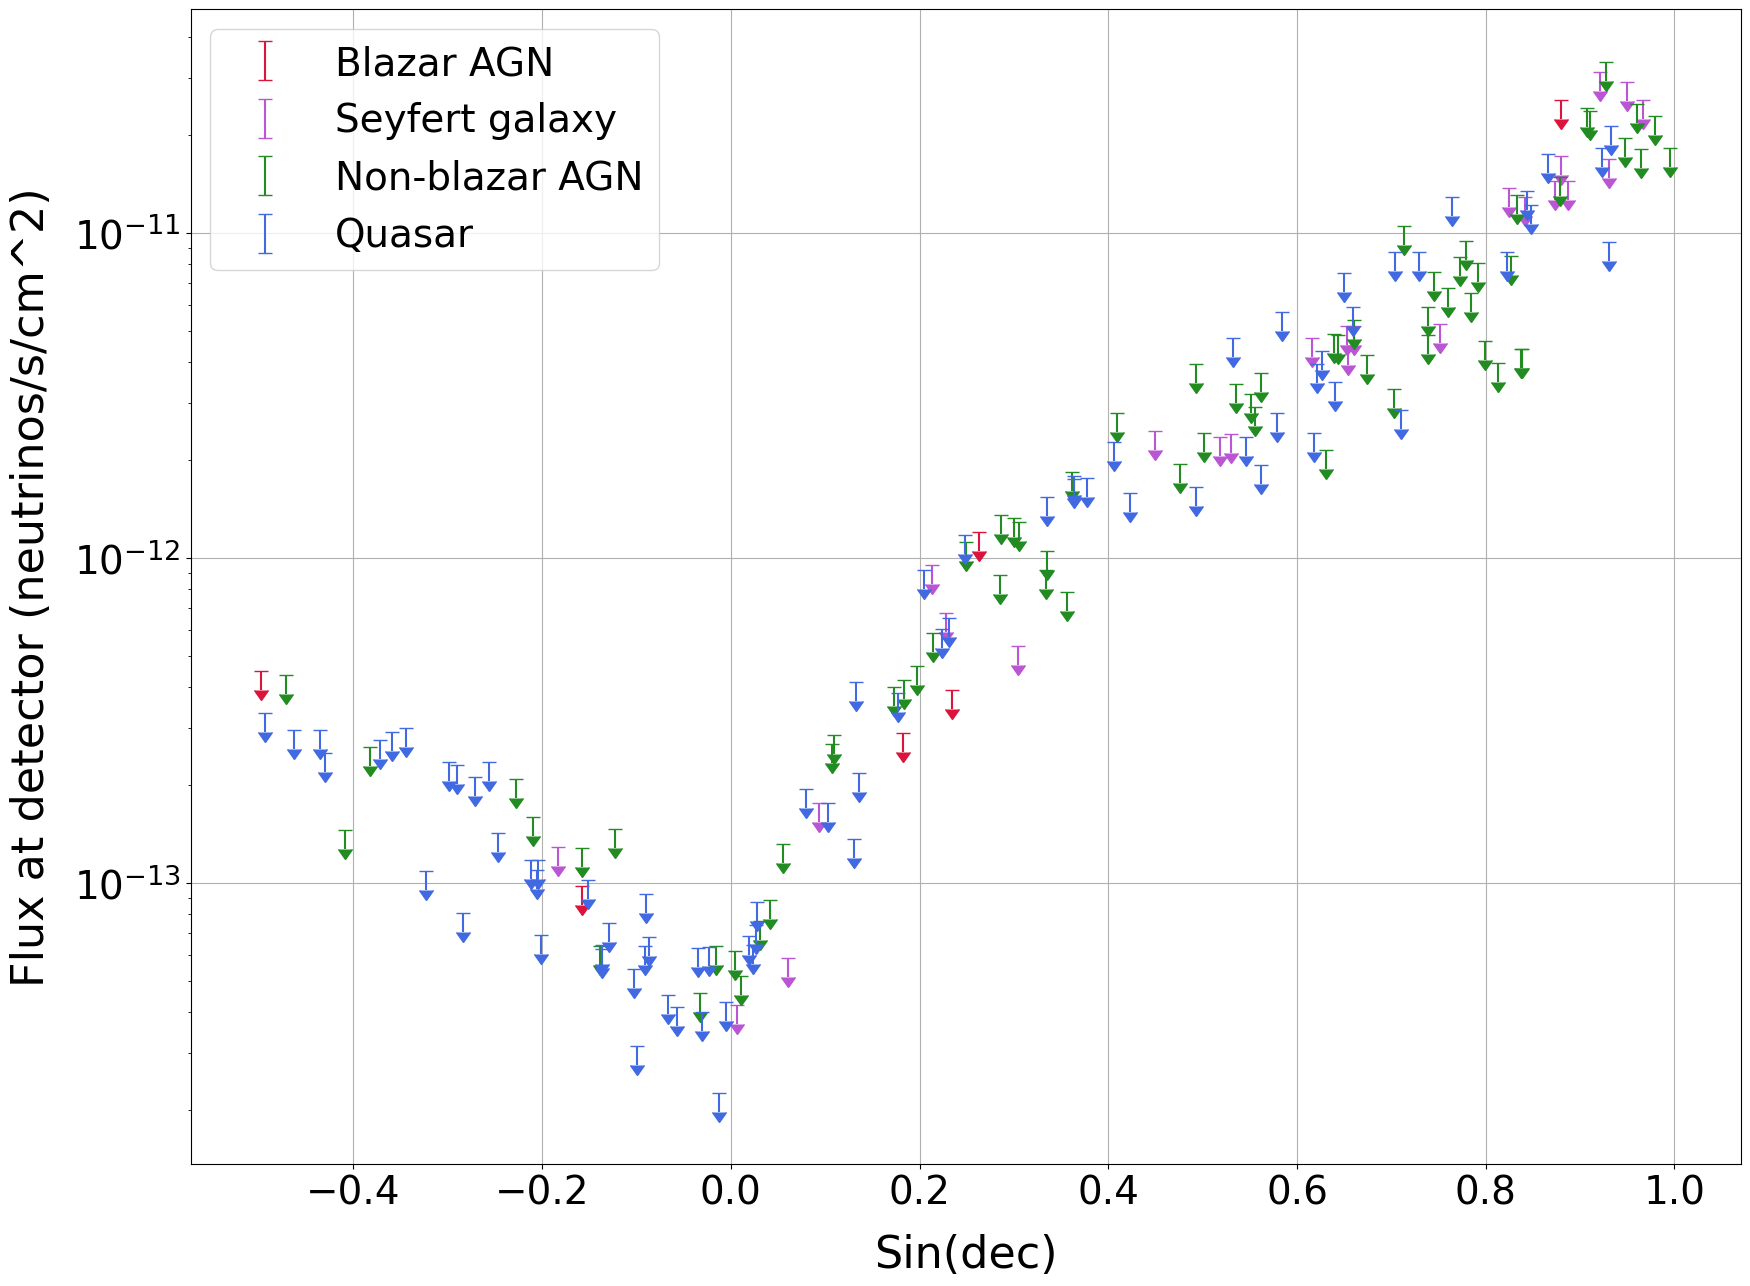

In [89]:
agn = np.logical_or(lim_type == agn_names[1], lim_type == agn_names[0])
blazar = np.logical_or(lim_type == blazar_names[1], lim_type == blazar_names[0])
radio = np.logical_or(lim_type == radio_names[1], lim_type == radio_names[0])
sey = np.logical_or(lim_type == sey_names[1], lim_type == sey_names[0])
qso = np.logical_or(lim_type == qso_names[0], lim_type == qso_names[0])
bll = np.logical_or(lim_type == bll_names[0], lim_type == bll_names[1])
other = np.logical_or(lim_type == other_names[0], lim_type== other_names[1])



plt.figure(figsize = (20,15))
plt.errorbar(np.sin(np.deg2rad(lim_dec))[blazar], lim_flux[blazar], yerr = (10**(-.9))*lim_flux[blazar], capsize = 5, uplims = True, ls = "none", c = "crimson", label = "Blazar AGN")
plt.errorbar(np.sin(np.deg2rad(lim_dec))[sey], lim_flux[sey], yerr = (10**(-.9))*lim_flux[sey], capsize = 5, uplims = True, ls = "none", c = "mediumorchid", label = "Seyfert galaxy")
plt.errorbar(np.sin(np.deg2rad(lim_dec))[np.logical_or(bll, other)], lim_flux[np.logical_or(bll, other)], yerr = (10**(-.9))*lim_flux[np.logical_or(bll, other)], capsize = 5, uplims = True, ls = "none", c = "forestgreen", label = "Non-blazar AGN")
plt.errorbar(np.sin(np.deg2rad(lim_dec))[qso], lim_flux[qso], yerr = (10**(-.9))*lim_flux[qso], capsize = 5, uplims = True, ls = "none", c = "royalblue", label = "Quasar")
#plt.scatter(np.sin(np.deg2rad(lim_dec)), lim_flux) 

plt.yscale('log')
plt.xlabel("Sin(dec)", fontsize = 32, labelpad= 15)
plt.ylabel("Flux at detector (neutrinos/s/cm^2)", fontsize = 32, labelpad = 15)
plt.yticks(fontsize=28)
plt.grid()
plt.legend(loc = "upper left", fontsize = 28)
plt.xticks(fontsize = 28)
plt.savefig("./Flux_lim_dec_dep.pdf", format = "pdf")
plt.show()

In [91]:
agn = np.logical_or(lim_type[descending_sort] == agn_names[1], lim_type[descending_sort] == agn_names[0])
blazar = np.logical_or(lim_type[descending_sort] == blazar_names[1], lim_type[descending_sort] == blazar_names[0])
radio = np.logical_or(lim_type[descending_sort] == radio_names[1], lim_type[descending_sort] == radio_names[0])
sey = np.logical_or(lim_type[descending_sort] == sey_names[1], lim_type[descending_sort] == sey_names[0])
qso = np.logical_or(lim_type[descending_sort] == qso_names[0], lim_type[descending_sort] == qso_names[0])
bll = np.logical_or(lim_type[descending_sort] == bll_names[0], lim_type[descending_sort] == bll_names[1])
other = np.logical_or(lim_type[descending_sort] == other_names[0], lim_type[descending_sort] == other_names[1])


6
77
30
68


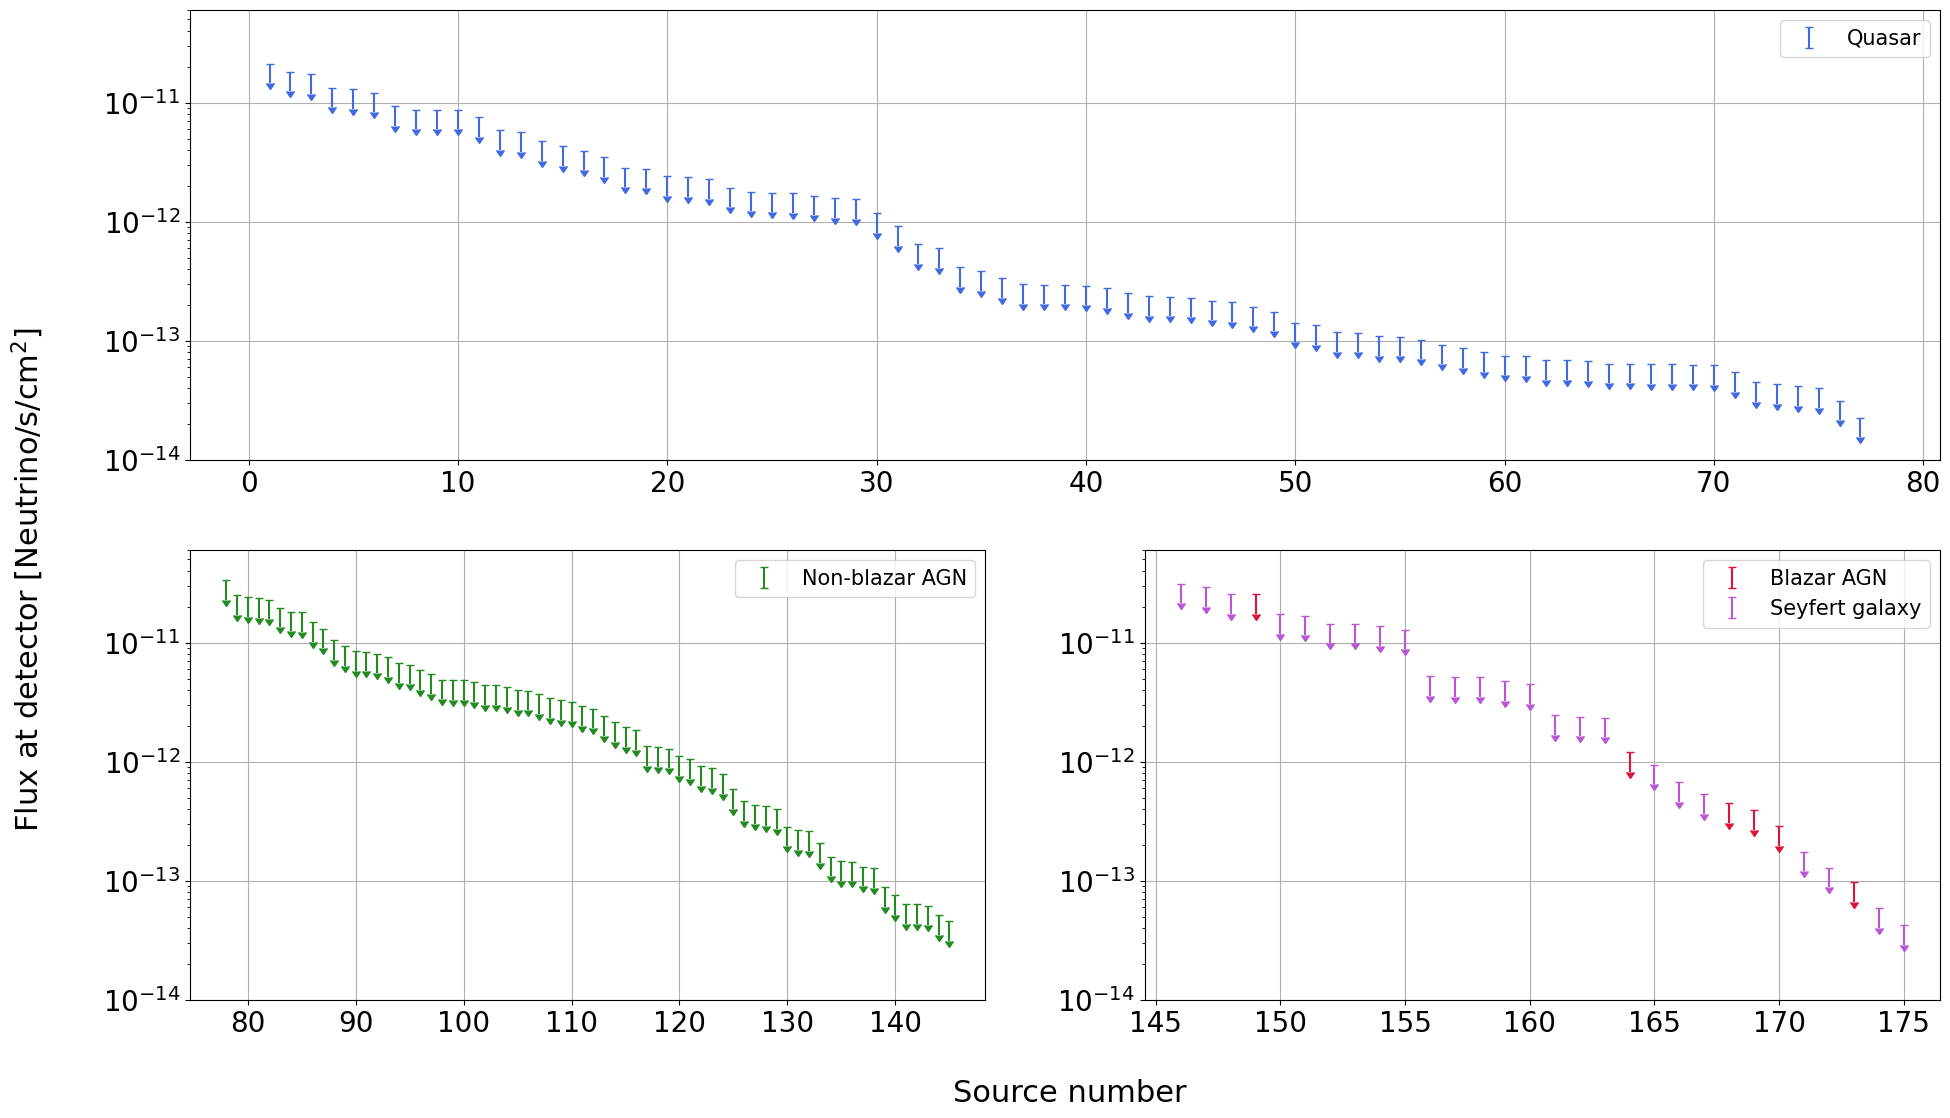

In [92]:
fig =plt.figure(figsize=(20,12))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.975, right=0.975)
print(len(blazar_number))
X = [ (2,2,(1,2)), (2,2,4), (2,2,3)]
for nrows, ncols, plot_number in X:
    sub = fig.add_subplot(nrows, ncols, plot_number)
    #sub.set_xticks([])
    #sub.set_yticks([])
    if plot_number == 4: 
        sub.errorbar(blazar_number,lim_flux[descending_sort][blazar], yerr = (10**(-.5))*lim_flux[descending_sort][blazar], capsize = 3, uplims = True, ls = "none", c = "crimson", label = "Blazar AGN")
        sub.errorbar(sey_number,lim_flux[descending_sort][sey], yerr = (10**(-.5))*lim_flux[descending_sort][sey], capsize = 3, uplims = True, ls = "none", c = "mediumorchid", label = "Seyfert galaxy")

        
        print(len(hi[blazar])+len(hi[sey]))
    if plot_number == 3: 
        sub.errorbar(agn_number,lim_flux[descending_sort][np.logical_or(bll, other)], yerr = (10**(-.5))*lim_flux[descending_sort][np.logical_or(bll, other)], capsize = 3, uplims = True, ls = "none", c = "forestgreen", label = "Non-blazar AGN")
        
        print(len(hi[bll])+len(hi[other]))
    if plot_number == (1,2): 

        sub.errorbar(qso_number,lim_flux[descending_sort][qso], yerr = (10**(-.5))*lim_flux[descending_sort][qso], capsize = 3, uplims = True, ls = "none", c = "royalblue", label = "Quasar")
        
        
        print(len(hi[qso]))
    sub.set_yscale("log")
    sub.legend(fontsize = 15)
    sub.grid()
    sub.tick_params(axis='both', which='major', labelsize=20)
    sub.set_ylim(10e-15,6e-11)

fig.supxlabel("Source number", fontsize = 22, y=0.06, x = .54)
fig.supylabel("Flux at detector [Neutrino/s/cm$^{2}$]", fontsize = 22, x = 0.01)
plt.savefig("./plots/upper_limits_new.pdf", dpi = 300)
